In [1]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35645 instead
  warnings.warn(


In [8]:
print(client)

<Client: 'tcp://10.0.128.155:44821' processes=3 threads=48, memory=131.31 GiB>


In [9]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [10]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [11]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [12]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [13]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [14]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [15]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [42]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))


In [43]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

In [44]:
# Load zeta data
VarToKeep = ['temp','z_rho0']#,'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

#load grid file
grid = makeROMSGridObject(truth)

truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)

truth = truth.drop('z_rho')
OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

truth["z_rho0"] = truth.z_rho0.fillna(0)
OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)

In [45]:
OSSE_SSHSST.nbytes/1024/1024

1599.8602142333984

In [46]:
truth.load(), print('done')
OSSE_SSHSST.load(), print('done')
OSSE_SSHSST_XBT_N.load(), print('done')
OSSE_SSHSST_XBT_S.load(), print('done')
OSSE_SSHSST_XBT.load(), print('done')


done
done
done
done
done


(<xarray.Dataset>
 Dimensions:     (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_rho: 272)
 Coordinates:
     z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.487 -1.039
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-12-31
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.58
 Attributes: (12/39)
     file:              roms_fwd_outer1.nc
     format:            netCDF-3 64bit offset file
     Conventions:       CF-1.4, SGRID-0.3
     type:              ROMS/TOMS history file
     title:             EAC OUTER GRID
     var_info:          varinfo.dat
     ...                ...
     compiler_command:  /apps/openmpi/4.1.0/

In [47]:
# calculate metrics

# RMSD_SSHSST_TRUTH_u_east  = (((OSSE_SSHSST.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_TRUTH_v_north = (((OSSE_SSHSST.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_TRUTH_temp    = (((OSSE_SSHSST.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_TRUTH_zeta    = (((OSSE_SSHSST.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_N_TRUTH_u_east  = (((OSSE_SSHSST_XBT_N.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_v_north = (((OSSE_SSHSST_XBT_N.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp    = (((OSSE_SSHSST_XBT_N.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_N_TRUTH_zeta    = (((OSSE_SSHSST_XBT_N.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_S_TRUTH_u_east  = (((OSSE_SSHSST_XBT_S.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_v_north = (((OSSE_SSHSST_XBT_S.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp    = (((OSSE_SSHSST_XBT_S.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_S_TRUTH_zeta    = (((OSSE_SSHSST_XBT_S.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

# RMSD_SSHSST_XBT_TRUTH_u_east  = (((OSSE_SSHSST_XBT.u_eastward.isel(s_rho=-1)-truth.u_eastward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_v_north = (((OSSE_SSHSST_XBT.v_northward.isel(s_rho=-1)-truth.v_northward.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp    = (((OSSE_SSHSST_XBT.temp.isel(s_rho=-1)-truth.temp.isel(s_rho=-1))**2).mean(dim="ocean_time"))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp500 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-500]))-horizontalSectionROMS(grid, truth.temp, np.array([-500])))**2).mean(dim='ocean_time'))**(1/2)
# RMSD_SSHSST_XBT_TRUTH_zeta    = (((OSSE_SSHSST_XBT.zeta-truth.zeta)**2).mean(dim="ocean_time"))**(1/2)

In [48]:

RMSD_SSHSST_TRUTH_temp250       = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp250 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp250 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp250   = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-250]))-horizontalSectionROMS(grid, truth.temp, np.array([-250])))**2).mean(dim='ocean_time'))**(1/2)

RMSD_SSHSST_TRUTH_temp1000       = (((horizontalSectionROMS(grid, OSSE_SSHSST.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_N_TRUTH_temp1000 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_N.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_S_TRUTH_temp1000 = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT_S.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)
RMSD_SSHSST_XBT_TRUTH_temp1000   = (((horizontalSectionROMS(grid, OSSE_SSHSST_XBT.temp, np.array([-1000]))-horizontalSectionROMS(grid, truth.temp, np.array([-1000])))**2).mean(dim='ocean_time'))**(1/2)


In [49]:
def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output




In [50]:
truth_temp250 = horizontalSectionROMS(grid, truth.temp, np.array([-250])).mean(dim='ocean_time')
truth_temp500 = horizontalSectionROMS(grid, truth.temp, np.array([-500])).mean(dim='ocean_time')
truth_temp1000 = horizontalSectionROMS(grid, truth.temp, np.array([-1000])).mean(dim='ocean_time')


Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

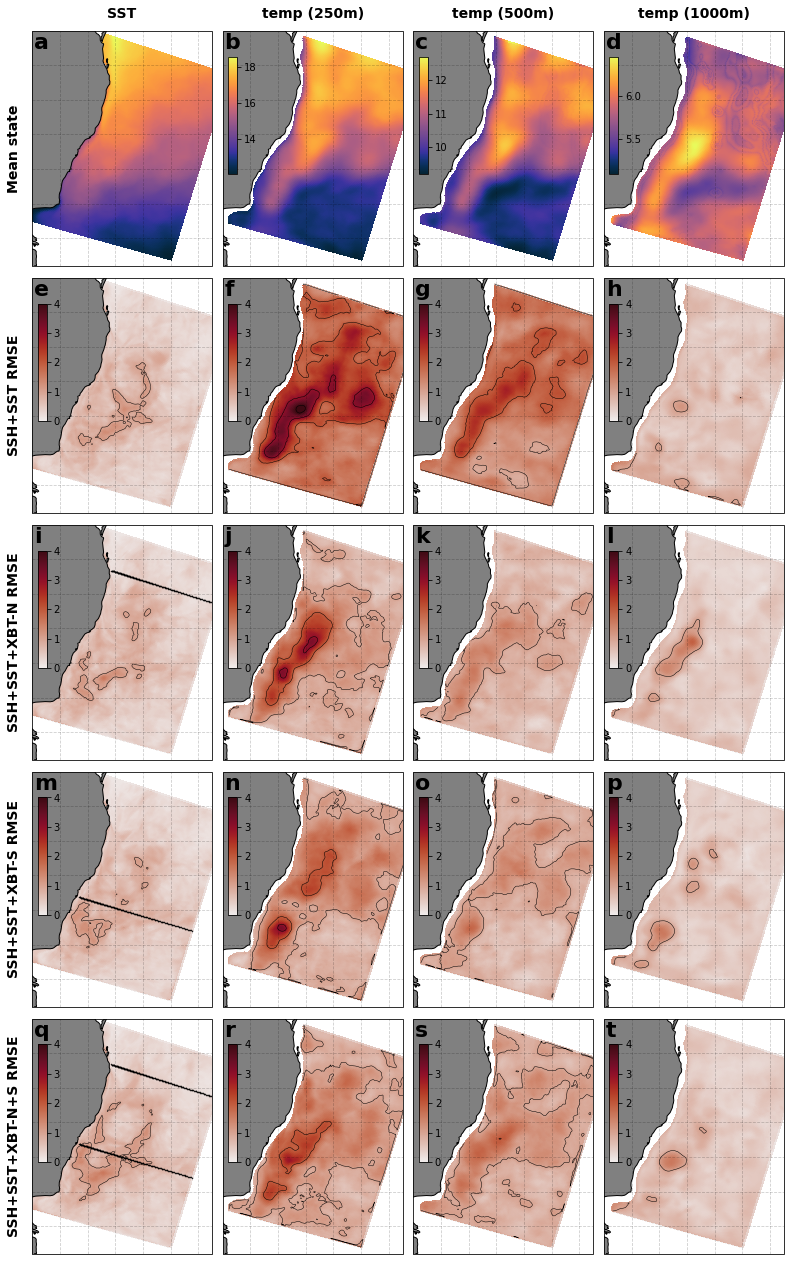

In [51]:
## define

def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax



# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=5,ncols=4,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[13.5,22.5])
ax = None



levels=np.arange(-100,110,25)

# add plots
# top row
ax7 = addSubplot_spatialMap_pcolor(truth.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'SST',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)
ax7.text(-.1, .5, 'Mean state',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp250   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'temp (250m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp500   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'temp (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp1000   ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(0.5, 1.1, 'temp (1000m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_salt500   ,gs,0,4,'e',pcol_kwargs={'cmap':'cmo.haline'})
# ax7.text(0.5, 1.1, 'salt (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)


## OSSE_SSHSST row

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp   ,gs,1,0,'e',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
ax7.text(-.1, .5, 'SSH+SST RMSE',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax7.transAxes)
RMSD_SSHSST_TRUTH_temp.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax7.set_title('')
ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp250   ,gs,1,1,'f',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_TRUTH_temp250.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax7.set_title('')
ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp500   ,gs,1,2,'g',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax7.set_title('')
ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp1000   ,gs,1,3,'h',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax8.set_title('')
# ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_salt500   ,gs,1,4,'j',)

## OSSE_SSHSST_XBT_N row
ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp   ,gs,2,0,'i',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
ax5.text(-.1, .5, 'SSH+SST+XBT-N RMSE',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
RMSD_SSHSST_XBT_N_TRUTH_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp250   ,gs,2,1,'j',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_N_TRUTH_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp500,gs,2,2,'k',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_N_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(RMSD_SSHSST_XBT_N_TRUTH_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp1000   ,gs,2,3,'l',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_N_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_salt500   ,gs,2,4,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_N_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

## OSSE_SSHSST_XBT_S row
ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp   ,gs,3,0,'m',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
ax5.text(-.1, .5, 'SSH+SST+XBT-S RMSE',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
RMSD_SSHSST_XBT_S_TRUTH_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp250   ,gs,3,1,'n',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_S_TRUTH_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp500 ,gs,3,2,'o',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_S_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp1000   ,gs,3,3,'p',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_S_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_salt500   ,gs,3,4,'t',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_S_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

## OSSE_SSHSST_XBT row
ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp   ,gs,4,0,'q',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax5.text(-.1, .5, 'SSH+SST+XBT-N+S RMSE',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax5.transAxes)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
RMSD_SSHSST_XBT_TRUTH_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp250   ,gs,4,1,'r',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_TRUTH_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp500   ,gs,4,2,'s',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp1000   ,gs,4,3,'t',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':4})
RMSD_SSHSST_XBT_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,6,1),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_salt500   ,gs,4,4,'y',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')



In [52]:
STOP

NameError: name 'STOP' is not defined

Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

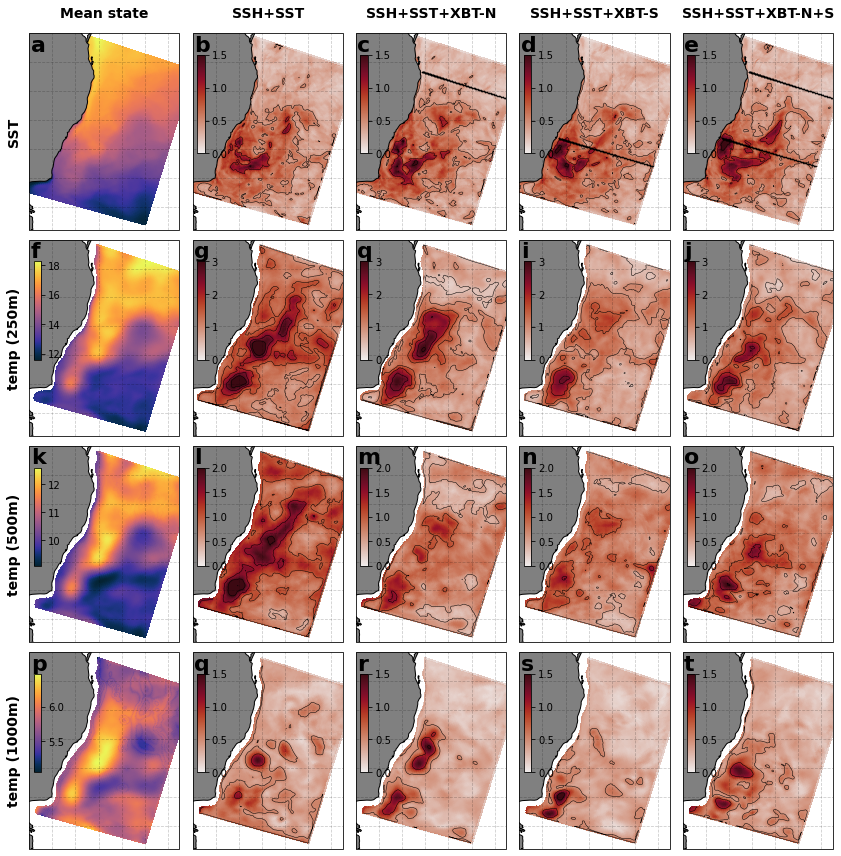

In [39]:
## define

def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_contourf(input,levels,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.contourf(input.lon_rho,input.lat_rho,input,levels,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax


def addSubplot_spatialMap_pcolor(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
#     cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.07,.39, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
#     fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax

def addSubplot_spatialMap_pcolor_colorbar(input,gs,nrow,ncol, labelText=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.03,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax



# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=4,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14.5,15])
ax = None



levels=np.arange(-100,110,25)

# add plots
# top row
ax7 = addSubplot_spatialMap_pcolor(truth.temp.isel(s_rho=-1).mean(dim='ocean_time')   ,gs,0,0,'a',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(-.1, .5, 'SST',fontsize=14, fontweight='bold', ha='center', rotation='vertical', va='center', transform=ax7.transAxes)
ax7.text(0.5, 1.1, 'Mean state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp250   ,gs,1,0,'f',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(-.1, .5, 'temp (250m)',fontsize=14, fontweight='bold', ha='center', rotation='vertical', va='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp500   ,gs,2,0,'k',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(-.1, .5, 'temp (500m)',fontsize=14, fontweight='bold', ha='center', rotation='vertical', va='center', transform=ax7.transAxes)

ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_temp1000   ,gs,3,0,'p',pcol_kwargs={'cmap':'cmo.thermal'})
ax7.text(-.1, .5, 'temp (1000m)',fontsize=14, fontweight='bold', ha='center', rotation='vertical', va='center', transform=ax7.transAxes)

# ax7 = addSubplot_spatialMap_pcolor_colorbar(truth_salt500   ,gs,0,4,'e',pcol_kwargs={'cmap':'cmo.haline'})
# ax7.text(0.5, 1.1, 'salt (500m)',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax7.transAxes)


## OSSE_SSHSST row

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp   ,gs,0,1,'b',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
ax7.text(0.5, 1.1, 'SSH+SST',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax7.transAxes)
RMSD_SSHSST_TRUTH_temp.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax7.set_title('')
ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp250   ,gs,1,1,'g',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
RMSD_SSHSST_TRUTH_temp250.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax7.set_title('')
ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp500   ,gs,2,1,'l',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':2})
RMSD_SSHSST_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax7.set_title('')
ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_temp1000   ,gs,3,1,'q',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
RMSD_SSHSST_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax8.set_title('')
# ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_TRUTH_salt500   ,gs,1,4,'j',)

## OSSE_SSHSST_XBT_N row
ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp   ,gs,0,2,'c',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
ax5.text(0.5, 1.1, 'SSH+SST+XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax5.transAxes)
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
RMSD_SSHSST_XBT_N_TRUTH_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp250   ,gs,1,2,'q',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
RMSD_SSHSST_XBT_N_TRUTH_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp500,gs,2,2,'m',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':2})
RMSD_SSHSST_XBT_N_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(RMSD_SSHSST_XBT_N_TRUTH_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_N_TRUTH_temp1000   ,gs,3,2,'r',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
RMSD_SSHSST_XBT_N_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_N_salt500   ,gs,2,4,'o',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_N_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_N_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

## OSSE_SSHSST_XBT_S row
ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp   ,gs,0,3,'d',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
ax5.text(0.5, 1.1, 'SSH+SST+XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax5.transAxes)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
RMSD_SSHSST_XBT_S_TRUTH_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp250   ,gs,1,3,'i',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
RMSD_SSHSST_XBT_S_TRUTH_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp500 ,gs,2,3,'n',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':2})
RMSD_SSHSST_XBT_S_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_S_TRUTH_temp1000   ,gs,3,3,'s',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
RMSD_SSHSST_XBT_S_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_S_salt500   ,gs,3,4,'t',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_S_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_S_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

## OSSE_SSHSST_XBT row
ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp   ,gs,0,4,'e',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax5.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
ax5.text(0.5, 1.1, 'SSH+SST+XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax5.transAxes)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
RMSD_SSHSST_XBT_TRUTH_temp.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
ax5.set_title('')

ax5 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp250   ,gs,1,4,'j',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':3})
RMSD_SSHSST_XBT_TRUTH_temp250.plot.contour(ax=ax5, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax5.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp250,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax5.transAxes)
ax5.set_title('')

ax7 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp500   ,gs,2,4,'o',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':2})
RMSD_SSHSST_XBT_TRUTH_temp500.plot.contour(ax=ax7, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax7.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax7.transAxes)
ax7.set_title('')

ax8 = addSubplot_spatialMap_pcolor_colorbar(RMSD_SSHSST_XBT_TRUTH_temp1000   ,gs,3,4,'t',pcol_kwargs={'cmap':'cmo.amp','vmin':0,'vmax':1.5})
RMSD_SSHSST_XBT_TRUTH_temp1000.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(0,3.5,.5),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_temp1000,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
ax8.set_title('')

# ax8 = addSubplot_spatialMap_pcolor(I_XBT_salt500   ,gs,4,4,'y',pcol_kwargs={'cmap':'cmo.balance','vmin':-100,'vmax':100})
# I_XBT_salt500.plot.contour(ax=ax8, x='lon_rho',y='lat_rho',levels=np.arange(-100,125,25),colors='k',zorder=12,linewidths=0.5)
# ax8.text(.9, .05, str(np.round(calc_areaAverageROMS(I_XBT_salt500,truth).values,1))+'%',fontsize=10, va='center', ha='center', transform=ax8.transAxes)
# ax8.set_title('')

